In [3]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
from scipy.signal import welch
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, deepSkip, localRFM, localDeepRFM
# import parallel_euler as arch1
import torch
from torch import nn
import glob, shutil
import config as cf

L = 200
dynamical_system = f'KS-{L}'
folder = f'../data/{dynamical_system}'
config = 'config_1' 
summary = ut.summary(dynamical_system)[config]
kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
          22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
          12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003},\
         '13_5':{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.059},\
         '200-001':{'error_threshold': 0.25, 'dt': 0.001, 'Lyapunov_time': 1/0.094},\
         '200-01':{'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/0.094},}

**Find optimal localization**

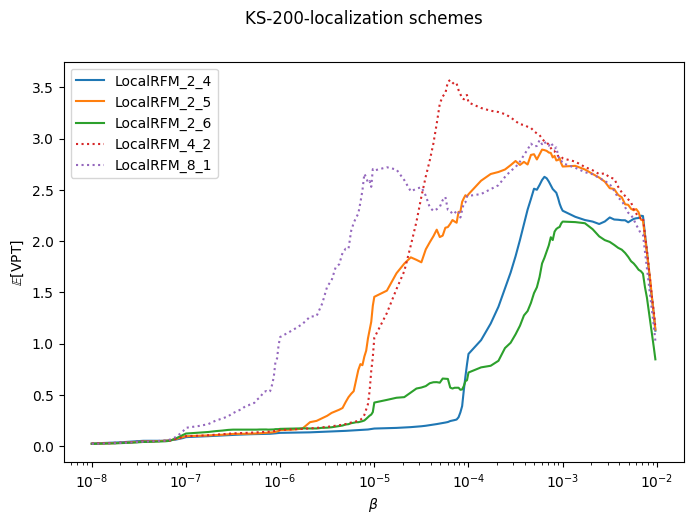

In [8]:
config = 'config_local'
architectures = ['LocalRFM']#, 'LocalDeepSkip']
GI = [[2, 4], [2, 5], [2, 6], [4, 2], [8, 1]]
localizations = [GI, GI]
D_rB = [[4096, 1]] * len(GI)
structures = [D_rB, D_rB]
markers = ['x', 'v']
fig = plt.figure(figsize=(8, 5.2))
ax = fig.add_subplot(111)
smoothing_window = 15
for i, architecture in enumerate(architectures):
    for j, localization in enumerate(localizations[i]):
        G, I = localization
        D_r, B = structures[i][j]
        if G==1:
            linestyle = 'dashed'
        elif G==2:
            linestyle = 'solid'
        elif G==4:
            linestyle = 'dotted'
        data = pd.read_csv(f'{folder}/{config}/{architecture}_{G}_{I}/beta/beta_D_r-{D_r}_B-{B}.csv')
        x, y = data['beta'], data['tau_f_nmse_mean']
        y = ut.smooth(y, smoothing_window)
        ax.semilogx(x, y, label=f'{architecture}_{G}_{I}', linestyle=linestyle)#, s=20, marker=markers[i])
ax.legend()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$')
# ax.set_xlim((1e-14, 2e-5))
fig.suptitle(f'{dynamical_system}-localization schemes')
plt.savefig(f'../data/plots/{dynamical_system}-localization-schemes.png', bbox_inches='tight', dpi=300)

**Violin plot of VPT**

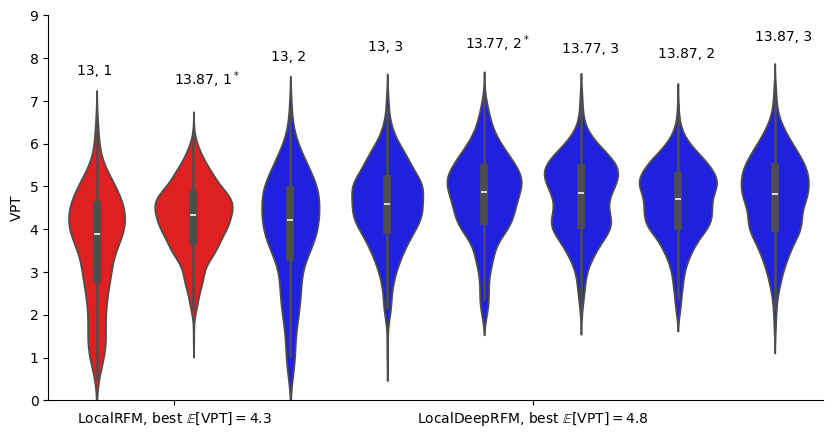

In [15]:
config = 'config_1'
architectures = {'config_1':['LocalRFM_8_1', 'LocalDeepRFM_8_1']}
colors = {'config_1_s':['r', 'b', 'g', 'deeppink'], 'config_1':['r', 'b', 'g', 'deeppink']}
x_pos = {'config_1_s':[1.5], 'config_1':[0.8, 4.5]}
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
smoothing_window = 5
m, n = 0, 0
params = []
best = []
for i, architecture in enumerate(architectures[config]):
    df_data = {'#params': [], 'vpt': []}
    subfolders = [x for x in glob.glob(f'{folder}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv') and "13308" not in x]
    sizes = [[x[2], x[3]] for x in list(map(ut.get_arch, subfolders))]
    subfolders = [x for _, x in sorted(zip(sizes, subfolders))]
    
    n += len(subfolders)-1 
    best += [max(summary[architecture].values())]
    for subfolder in subfolders:
        arch = ut.get_arch(subfolder)
        data = pd.read_csv(f'{subfolder}/batch_data.csv')
        vpt = data['tau_f_nmse']
        p = np.log10(arch[-1])
        df_data['#params'] += [m] * len(vpt)
        df_data['vpt'] += vpt.to_list()
        params += [p]
        if arch[2] == 13308:
            logdr = "13.7"
        elif arch[2] == 14000:
            logdr = "13.77"
        elif arch[2] == 15000:
            logdr = "13.87"
        else:
            logdr = int(np.log2(arch[2]))
        text = r"{}, {}".format(logdr, arch[3])
        if vpt.mean() == best[-1]:
            text += r'$^*$'
        ax.text(m-0.2, vpt.max()+1.1, text)
        m += 1
    df = pd.DataFrame(df_data)
    sns.violinplot(data=df, x="#params", y="vpt", ax=ax, color=colors[config][i])  
ax.set_xticks(x_pos[config], labels=[architectures[config][i].split('_')[0] + r', best $\mathbb{E}[\rm VPT]=$' + f'{best[i]:.1f}' for i in range(len(architectures[config]))])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'')
ax.set_ylabel(r'${\rm VPT}$')
ax.set_ylim((0, 9))
# ax.set_ylim((0, 70))
# fig.suptitle('L96-localization schemes')
plt.savefig(f'../data/plots/{dynamical_system}-{config}-vpt-violin.pdf', bbox_inches='tight', dpi=1200)

**Runtime and model size**

['SkipRFM', 40, 4096, 1, 331776]
['SkipRFM', 40, 8192, 1, 663552]
['SkipRFM', 40, 1024, 1, 82944]
['SkipRFM', 40, 512, 1, 41472]
['SkipRFM', 40, 2048, 1, 165888]
['DeepSkip', 40, 4096, 8, 3964928]
['DeepSkip', 40, 4096, 1, 495616]
['DeepSkip', 40, 4096, 16, 7929856]
['DeepSkip', 40, 4096, 4, 1982464]
['DeepSkip', 40, 4096, 2, 991232]
['LocalSkip_2_2', 40, 4096, 1, 2, 2, 53248]
['LocalSkip_2_2', 40, 8192, 1, 2, 2, 106496]
['LocalSkip_2_2', 40, 1024, 1, 2, 2, 13312]
['LocalSkip_2_2', 40, 512, 1, 2, 2, 6656]
['LocalSkip_2_2', 40, 2048, 1, 2, 2, 26624]
['LocalSkip_2_2', 40, 16384, 1, 2, 2, 212992]
['LocalDeepSkip_2_2', 40, 16384, 4, 2, 2, 983040]
['LocalDeepSkip_2_2', 40, 2048, 2, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 1024, 2, 2, 2, 30720]
['LocalDeepSkip_2_2', 40, 4096, 8, 2, 2, 491520]
['LocalDeepSkip_2_2', 40, 2048, 4, 2, 2, 122880]
['LocalDeepSkip_2_2', 40, 1024, 16, 2, 2, 245760]
['LocalDeepSkip_2_2', 40, 4096, 1, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 16384, 2, 2, 2, 491520]
['Local

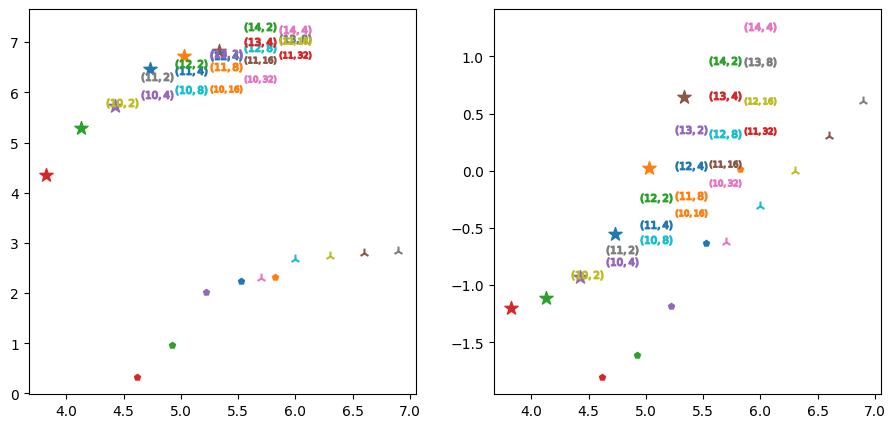

In [70]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
markers = {'SkipRFM': 'p', 'DeepSkip': '2', 'LocalSkip_2_2': '*', 'LocalDeepSkip_2_2': '.'}
s = {'SkipRFM': 20, 'DeepSkip': 50, 'LocalSkip_2_2': 80, 'LocalDeepSkip_2_2': 500}
for i, architecture in enumerate(architectures[config]):
    subfolders = [x for x in glob.glob(f'{folder}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv')]
    best += [max(summary[architecture].values())]
    for subfolder in subfolders:
        arch = ut.get_arch(subfolder)
        data = pd.read_csv(f'{subfolder}/batch_data.csv')
        vpt = data['tau_f_nmse']
        args = ut.get_arch(subfolder)
        print(args)
        if 'LocalDeepSkip' in architecture:
            if args[3] == 1:
                continue
            label = f'B={args[3]}'
            marker = fr"${(int(np.log2(args[2])), args[3])}$"
            if len(marker) > 9:
            
        else:
            label = None
            marker = markers[architecture]
            
        ax1.scatter(np.log10(arch[-1]), vpt.mean(), marker=marker, s=s[architecture])
        ax2.scatter(np.log10(arch[-1]), np.log10(data['train_time'].mean()), marker=marker, s=s[architecture])
# ax1.legend()

**Generate reconstructed attractor**

In [ ]:
L0, L1, N = 0.4, 3.5, int(1e5)
train = np.load(f"{folder}/train.npy")
train = torch.tensor(train)[:, :N]


# LocalRFM 
arch, D_r, B, G, I = 'LocalRFM_8_1', 15000, 1, 8, 1
save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
drf = localRFM.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
drf.learn(train, 42)
reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

# LocalDeepRFM
# arch, D_r, B, G, I = 'LocalDeepSkip_2_2', 1, 2, 8, 1
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = localDeepSkip.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

**Plot PSD data**

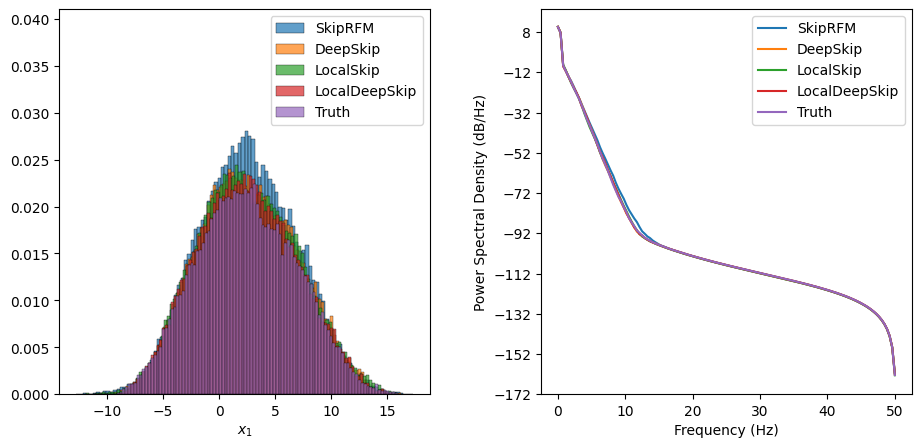

In [29]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
D_r, N = 4096, 100000
folders = [f"{folder}/{config}/SkipRFM/D_r-{D_r}_B-1", f"{folder}/{config}/DeepSkip/D_r-{D_r}_B-2",\
           f"{folder}/{config}/LocalSkip_2_2/D_r-{D_r}_B-1", f"{folder}/{config}/LocalDeepSkip_2_2/D_r-{D_r}_B-2", folder]
for i, data_folder in enumerate(folders):
    filename = "attractor" if i < len(folders)-1 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
    label = "Truth" if i == len(folders)-1 else ut.get_arch(data_folder)[0]
    label = label.split('_')[0]
    # x, y = welch(attractor.mean(axis=0), 100)
    ax2.psd(attractor.mean(axis=0), Fs=100, label=label)
    sns.histplot(attractor[0], ax=ax1, label=label, alpha=0.7, stat="probability", bins=100)
ax1.legend()
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('')
ax1.set_ylim((0, 0.041))
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('Frequency (Hz)')
fig.subplots_adjust(wspace=0.3)
plt.savefig('../data/plots/L96-climate.pdf', dpi=1200, bbox_inches="tight")

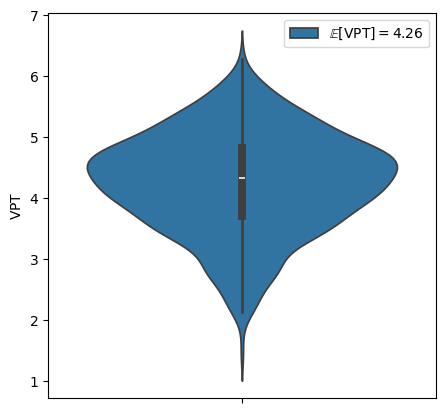

In [23]:
data = pd.read_csv(f'{folder}/{config}/LocalRFM_8_1/D_r-{15000}_B-{1}/batch_data.csv')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.violinplot(data['tau_f_nmse'], ax=ax, label = r'$\mathbb{E}[{\rm VPT}]=$' + f"{data['tau_f_nmse'].mean():.2f}")
ax.set_ylabel(r'${\rm VPT}$')
ax.legend()
plt.savefig('../data/plots/KS-200-D_r-15000.png', bbox_inches="tight", dpi=1200)

500

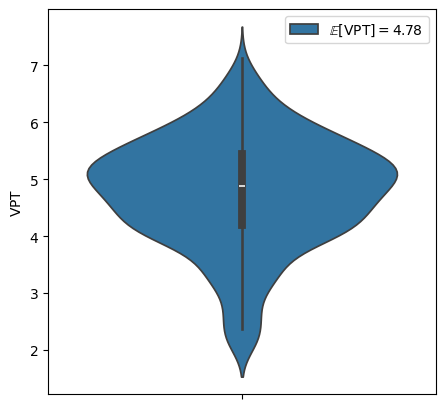

In [142]:
config, D_r, B = 'config_1', 14000, 2
data = pd.read_csv(f'{folder}/{config}/LocalDeepRFM_8_1/D_r-{D_r}_B-{B}/batch_data.csv')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.violinplot(data['tau_f_nmse'], ax=ax, label = r'$\mathbb{E}[{\rm VPT}]=$' + f"{data['tau_f_nmse'].mean():.2f}")
ax.set_ylabel(r'${\rm VPT}$')
ax.legend()
len(data)

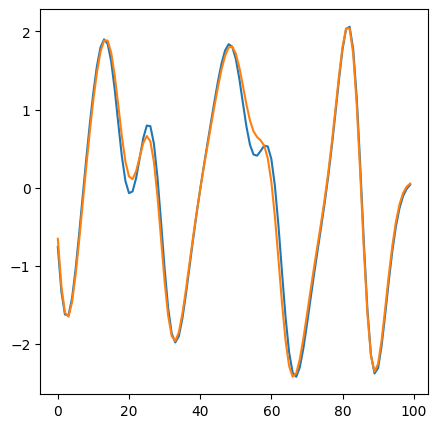

In [18]:
l = 200
u = np.load(f'../data/KS-{l}/train.npy')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(u[250:350, 1000])
ax.plot(u[250:350, 1001])


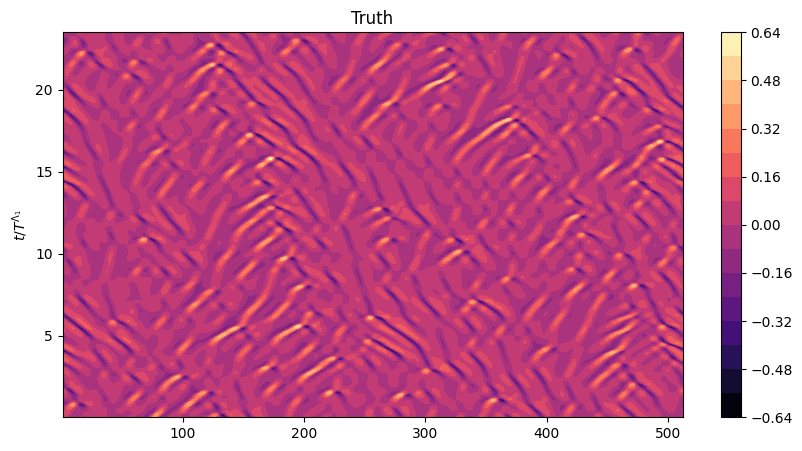

In [147]:
ut.waterfall(u[:, 1:1001]-u[:, :1000], **kwargs[l])

In [2]:
summary

{'LocalDeepRFM_8_1': {(8192, 4, 8, 1): 2.0668249999999997,
  (11586, 4, 8, 1): 2.9268780000000003,
  (8192, 2, 8, 1): 4.0182649999999995,
  (8192, 3, 8, 1): 4.5417510000000005,
  (13308, 6, 8, 1): 4.618924999999999,
  (13308, 5, 8, 1): 4.634341,
  (15000, 2, 8, 1): 4.637678,
  (15000, 3, 8, 1): 4.729515999999999,
  (14000, 3, 8, 1): 4.7380700000000004,
  (14000, 2, 8, 1): 4.782908},
 'LocalRFM_8_1': {(8192, 1, 8, 1): 3.630045,
  (15000, 1, 8, 1): 4.259422000000001}}